# Importing Libraries

We import the environment that is already coded for us :

In [1]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-71jqw6jb
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-71jqw6jb
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 5.3 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7772 sha256=ebed1039efd101aace4c552df0af0735f72cd6b02ca6a35fbacbb906145e89ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-g90bcyhd/wheels/41/44/75/c67b96ba782472d8cacb00e3af57e29d1ee3a14f2e95a59ce5
Successfully built text-flappy-bird-gym


In [2]:
import os, sys
import gymnasium as gym
import time
import numpy as np
from collections import defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import clear_output

import text_flappy_bird_gym
import pandas as pd

# Environment Analysis

`TextFlappyBird-v0` returns the horizontal and vertical distance of the player to the closest upcoming pipe gap.

In [3]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

## Action and Observation spaces

In [198]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(14), Discrete(22, start=-11))


We understand that we have 2 actions : `flap` (clicking on the screen) and `idle` (let the gravity do its job).

We have multiple observations : x distance ranges from 0 to 14 and y distance ranges from -11 to 11.

## Reset

Let's see how is composed an observation :

In [199]:
env.reset()

((13, 4), {'score': 0, 'player': [6, 7], 'distance': 13.601470508735444})

In [200]:
env.reset()

((13, -2), {'score': 0, 'player': [6, 7], 'distance': 13.152946437965905})

We understand that an observation is of structure :

 `( (dist_x, dist_y) , {score, player : [`x_position`, `y_position`], distance) )`

## Step

Let's see what the environment returns after a specific action is made :

In [201]:
action = 1
env.step(action)

((12, -3),
 1,
 False,
 False,
 {'score': 0, 'player': [6, 6], 'distance': 12.36931687685298})

We have this structure :

`((dist_x, dist_y), reward, done, False, {'score', 'player': [x_position, y_position], 'distance'})`

that is :

( (`dist_x`, `dist_y`) , `reward` (always=1), status report if the game is over, a boolean that is always `False`, dictionary with info : {`score`, [`player_position`], `distance`} )

# Random Policy

This will be our baseline.

The following script will print every frame of the game : randomly choosing an action (flap or idle) until the bird looses.

The next rendering will not plot every frame but the succession of each one.

In [202]:
if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset() #initial observation that is not used here

    # iterate
    while True:

        # Select next action
        action = env.action_space.sample() #we select randomly an action in the action space

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()


Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-5)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-6)
Text Flappy Bird!
Score: 0
----------------------
[     

Of course the score is 0, but at least we know that our environment is well settled.
Let's learn !

# Monte Carlo based agent

We know that there are 2 types of MC methods:
1. First-Visit Monte Carlo
2. Every-Visit Monte Carlo

Let's choose the first one with an epsilon-greedy policy. We define various function that will be called.

## Generate Probabilities of choosing an action

We have to keep in mind that the Q object generated in MC control is not an array of size (`num_states`, `num_actions`) but a dictionnary : `Q = defaultdict(lambda: np.zeros(num_actions))

Example :


```
defaultdict(<function __main__.<lambda>()>,
            {(13, 3): array([0.        , 0.95617925]),
             (12, 2): array([0.        , 0.86482753]),
             (11, 1): array([0.77255306, 0.        ]),
             (10, 2): array([0.67934652, 0.        ]),
             (9, 5): array([0.        , 0.58519851]),
             (8, 4): array([0.4900995, 0.       ]),
             (7, 5): array([0.       , 0.3940399]),
             (6, 4): array([0.29701, 0.     ]),
             (5, 5): array([0.199, 0.   ]),
             (4, 8): array([0.1, 0. ])})
```



So we can add any new state , as long as we have the 2 dimensions for the 2 actions in our case : Example `Q[(12,1)][0]` selects the state (12,1) addind a value for the first array.

In [4]:
def get_probs(Q_s, epsilon, nA): #it's an epsilon-greedy

    """ Returns the action probabilities corresponding to epsilon-greedy policy
    Q_s [defaultdict]
    epsilon [float]
    nA [int] : number of action"""

    policy_s = np.ones(nA) * epsilon / nA # base probability for each action in an epsilon-greedy policy.

    best_a =  np.argmax(Q_s) #epsilon-greedy policy, this action is considered the "best" action to take in the current state.

    policy_s[best_a] = 1 - epsilon + (epsilon / nA) #with probability 1 - epsilon, the agent will select the best action (exploitation), and with probability epsilon, it will select a random action from the entire action space (exploration).

    return policy_s #action probabilities corresponding to the epsilon-greedy policy for the given state-action value


## Generation of an episode

In MC method, we need to compute a whole episode until it terminates to be able to update the Q values.

In [5]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ Function that generates an episode following an epsilon-greedy policy

    env : environment
    Q [defaultdict],
    epsilon [float]
    nA [int]: number of actions"""

    episode = [] #sequence of (state, action, reward)
    state = env.reset()[0] #initial random state

    while True: #loop until end of the episode

        #choice of an action according to the probabilities generated by get_probs
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()

        # take a step in the environement
        next_state, reward, done,_, info =  env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break

    return episode

## Update of Q

After an episode is complited, we can udpate the according Q value.

Here we respect first-visit state MC.

In [6]:
def update_Q(env, episode, Q, alpha, gamma):

    """ updates the action-value function estimate using the most recent episode """

    states, actions, rewards = zip(*episode) #in episode, it's a list of tuples [(state = (dx, dy), action{0,1}, reward)]

    discounts = np.array([gamma**i for i in range(len(rewards)+1)]) # prepare an array for discounting, just gamma^i

    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] #actions is the array with all successive actions (0, 0, 1, 1, 1, 0, 1). So actions[i] = {0,1}
        Q[state][actions[i]] = old_Q + alpha * (sum(rewards[i:] * discounts[:-(i+1)]) - old_Q) ##gradient ascent
    return Q

## MC Control - making the agent learn

Finally, we can make our agent learn, that is updating our Q values following an epsilon greedy policy.

In [7]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05,max_steps=5000):
    nA = env.action_space.n #number of actions possible

    Q = defaultdict(lambda: np.zeros(nA)) # initialize empty dictionary of arrays

    epsilon = eps_start

    rewards = []  # List to store rewards obtained during training
    len_episodes = []

    for i_episode in tqdm(range(1, num_episodes+1)):  # loop over episodes

        epsilon = max(epsilon*eps_decay, eps_min) #we decay the epsilon

        # generate an episode by following epsilon-greedy policy
        episode =generate_episode_from_Q(env, Q, epsilon, nA)

        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)

        # calculate total reward for the episode and append to rewards list
        rewards.append(sum([triplet[2] for triplet in episode])) #in episode, we have (state, action, reward)
        len_episodes.append(len(episode))

        if len(episode)>max_steps:
          break


    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())

    return policy, Q ,rewards, len_episodes

In [8]:
# obtain the estimated optimal policy and action-value function
policy, Q , rewards,len_episodes = mc_control(env,
                                 num_episodes=20000,
                                 alpha=0.02,
                                 gamma=1.0,
                                 eps_start=1.0, #encourages exploration at the beginning of training
                                 eps_decay=.999,
                                 eps_min=0.05)

 18%|█▊        | 3632/20000 [00:36<02:44, 99.20it/s]


Let's take a look at our policy :

In [9]:
print(policy)

{(13, 4): 1, (12, 4): 1, (11, 3): 1, (10, 2): 1, (9, 1): 1, (8, 2): 1, (7, 1): 1, (6, 0): 0, (5, -1): 0, (4, -2): 0, (3, -3): 0, (2, -3): 0, (1, -3): 0, (0, -2): 0, (9, -7): 1, (8, -8): 0, (7, -9): 1, (6, -10): 0, (5, -11): 0, (4, -10): 0, (3, -7): 1, (2, -2): 1, (13, 3): 1, (12, 2): 1, (11, 1): 1, (10, 0): 1, (9, -1): 0, (8, 0): 1, (7, -1): 1, (6, -2): 1, (5, -3): 0, (4, -4): 0, (3, -4): 0, (2, -4): 0, (1, -4): 0, (13, 1): 1, (12, 0): 1, (10, 4): 1, (13, -5): 1, (12, -6): 0, (11, -5): 1, (10, -2): 1, (9, -3): 1, (8, -4): 1, (7, -5): 1, (6, -6): 1, (5, -7): 0, (4, -8): 0, (2, -8): 0, (1, -7): 0, (13, -4): 1, (12, -5): 1, (11, -6): 1, (10, -5): 1, (9, -6): 0, (8, -5): 1, (7, -6): 0, (6, -7): 0, (5, -8): 0, (4, -7): 0, (3, -8): 0, (2, -7): 1, (1, -8): 1, (13, -1): 1, (12, -2): 0, (11, -1): 1, (5, 1): 0, (4, 0): 1, (3, 1): 1, (2, 4): 0, (1, 3): 1, (6, 4): 1, (5, 3): 1, (4, 2): 1, (3, 3): 1, (2, 6): 1, (1, 11): 1, (12, -4): 1, (10, -6): 1, (7, -7): 0, (6, -8): 1, (3, -9): 0, (2, -10): 0, (

We have for each visited state (x_dist, y_dist) an associated action 0 or 1.

## Game Play

Now we can see if our bird flies correctly ! In the next function, we define the number of frames we will display as the agent always wins.

In [10]:
def play_game(env, policy, num_frames=20, sleep_time = 0.2):

  """Function that plays the game for a certain number of frames

  env : given environment
  policy[defaultdict] : policy after the agent has been trained
  num_frames[int] : number of frames that will be displayed """

  obs = env.reset() #initial observation eg ((13, -5), {'score': 0, 'player': [6, 7], 'distance': 13.92838827718412})
  state = obs[0] #initial state. eg (13, -5)

  # iterate over the number of frames : each frame in another (state, action)
  for _ in range(num_frames):
      print("state", state)
      action = policy[state]
      print("action", action)

      # Appy action and return new observation of the environment
      state, reward, done, _, info = env.step(action)

      # Clear the output cell
      clear_output(wait=True)

      # Render the game
      sys.stdout.write(env.render())
      time.sleep(sleep_time)  # FPS
      sys.stdout.flush()  # Flush the output buffer
      # If player is dead break
      if done:
          break
  env.close()

In [11]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
play_game(env, policy,num_frames=50)

Text Flappy Bird!
Score: 4
----------------------
[         |          ]
[         |          ]
[         |          ]
[                    ]
[                    ]
[                    ]
[                    ]
[         |          ]
[         |          ]
[      @  |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=3,dy=4)


We have a pretty stressful bird ! I feel that it waits the last minute to flap before reaching a door.

# Reward Curves

We define a function that plot the cumulative reward over the number of episode, for different hyperparameters.

## Reward Plot Function

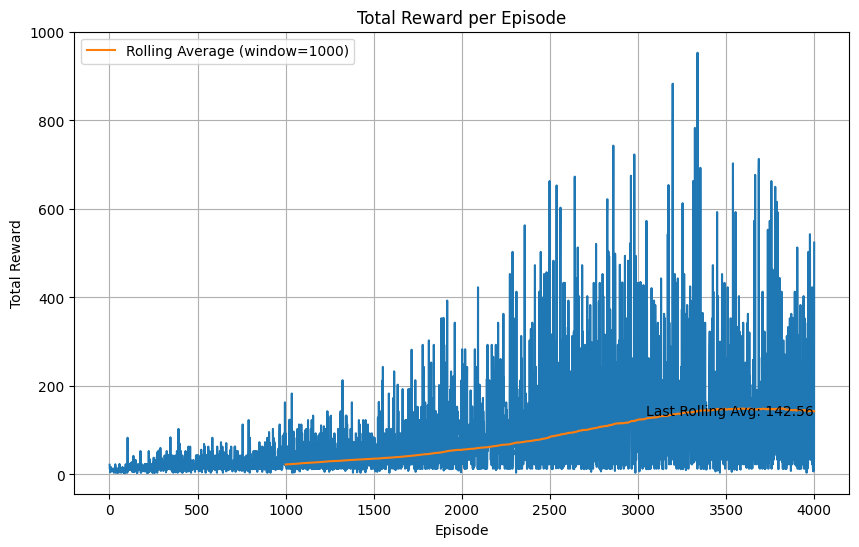

In [44]:
def reward_plot(rewards, rolling_window = 1000):
    plt.figure(figsize = (10,6))
    plt.plot(np.arange(1, len(rewards) + 1), rewards)

    # Calculate rolling average
    rolling_average = pd.Series(rewards).rolling(window=rolling_window).mean()

    # Plot the rolling average
    plt.plot(np.arange(1, len(rewards) + 1), rolling_average, label='Rolling Average (window=1000)')

    last_rolling_avg = rolling_average.iloc[-1]
    plt.text(len(rewards), last_rolling_avg, f'Last Rolling Avg: {last_rolling_avg:.2f}', ha='right', va='center')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.grid(True)
    plt.legend()
    plt.show()

reward_plot(rewards)

## Hyperparameters tuning

### epsilon

 14%|█▍        | 2883/20000 [00:16<01:40, 170.95it/s]


Epsilon Starts at : 1


 14%|█▍        | 2820/20000 [00:15<01:33, 183.89it/s]


Epsilon Starts at : 0.95


 18%|█▊        | 3694/20000 [00:29<02:08, 126.50it/s]


Epsilon Starts at : 0.9


 14%|█▎        | 2705/20000 [00:14<01:35, 180.81it/s]


Epsilon Starts at : 0.8


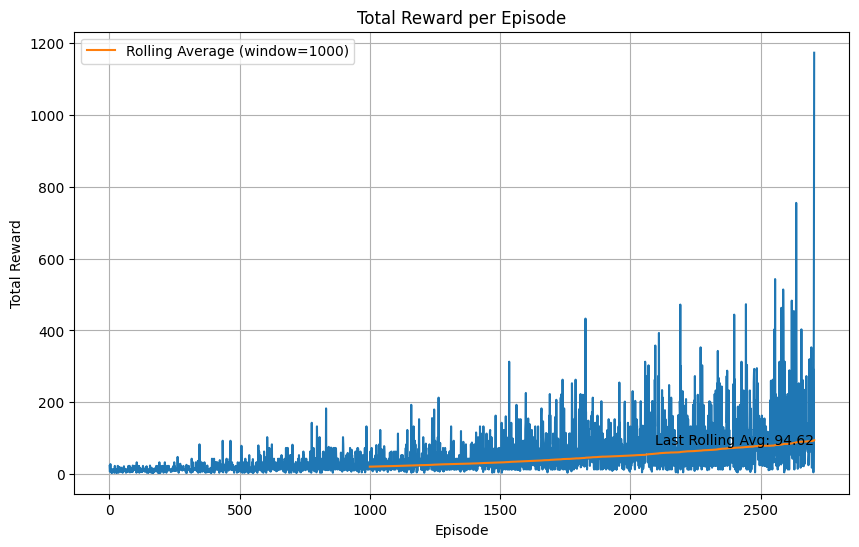

 17%|█▋        | 3362/20000 [00:20<01:42, 161.61it/s]


Epsilon Starts at : 0.7


 17%|█▋        | 3485/20000 [00:24<01:54, 143.69it/s]


Epsilon Starts at : 0.6


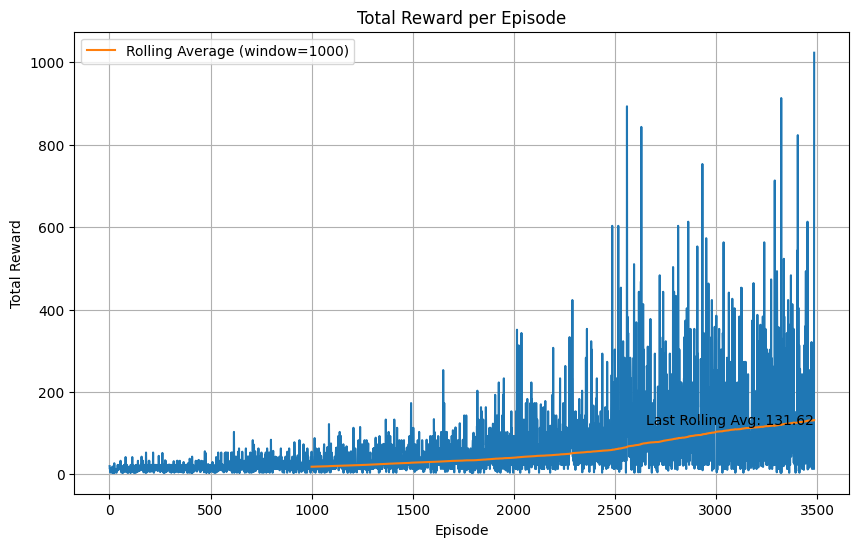

In [213]:
epsilons_start = [1,0.95,0.9,0.8,0.7,0.6]

for epsilon in epsilons_start :

  policy, Q , rewards,len_episodes = mc_control(env,
                                 num_episodes=20000,
                                 alpha=0.02,
                                 gamma=1.0,
                                 eps_start=epsilon,
                                 eps_decay=.999,
                                 eps_min=0.05,
                                max_steps = 1000)

  print("Epsilon Starts at :",epsilon )
  reward_plot(rewards)

### Epsilon decay

100%|██████████| 10000/10000 [00:14<00:00, 676.90it/s]


Epsilon Decay of : 0.99999


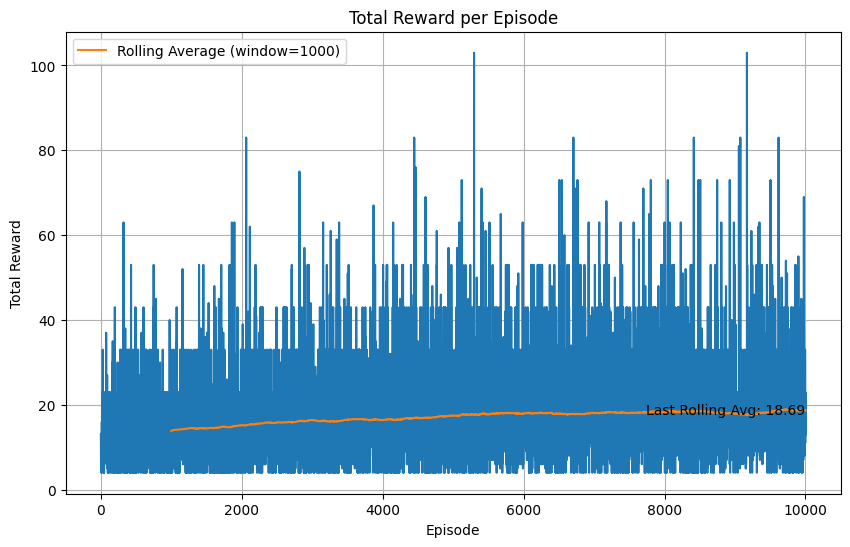

100%|██████████| 10000/10000 [00:25<00:00, 395.88it/s]


Epsilon Decay of : 0.9999


100%|██████████| 10000/10000 [00:51<00:00, 195.95it/s]


Epsilon Decay of : 0.999


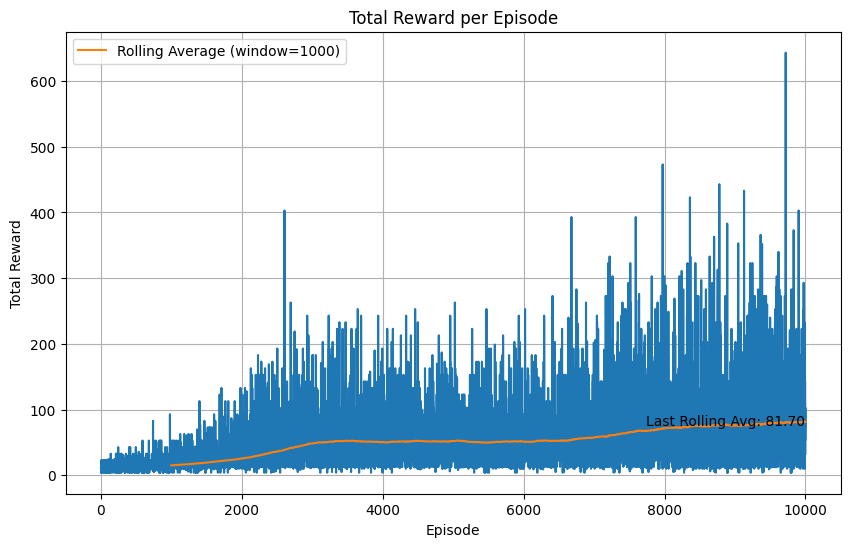

100%|██████████| 10000/10000 [00:17<00:00, 564.26it/s]


Epsilon Decay of : 0.99


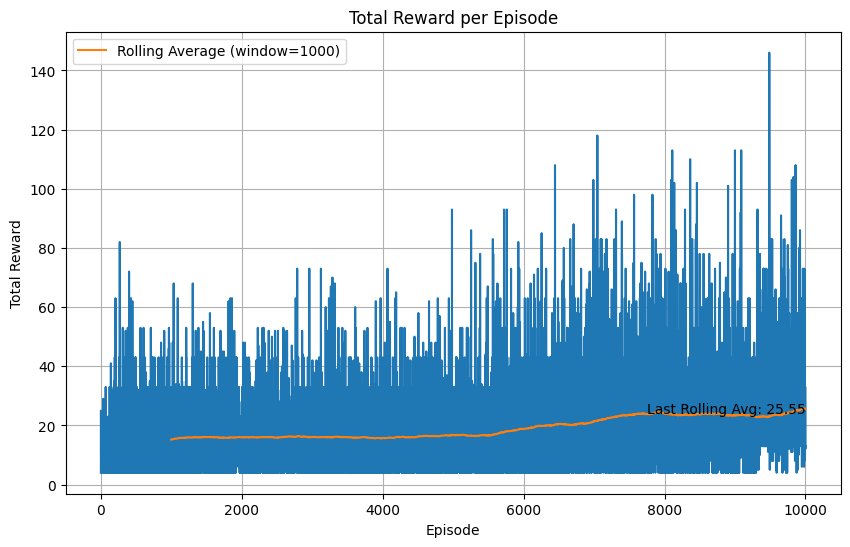

100%|██████████| 10000/10000 [00:14<00:00, 712.42it/s]


Epsilon Decay of : 0.9


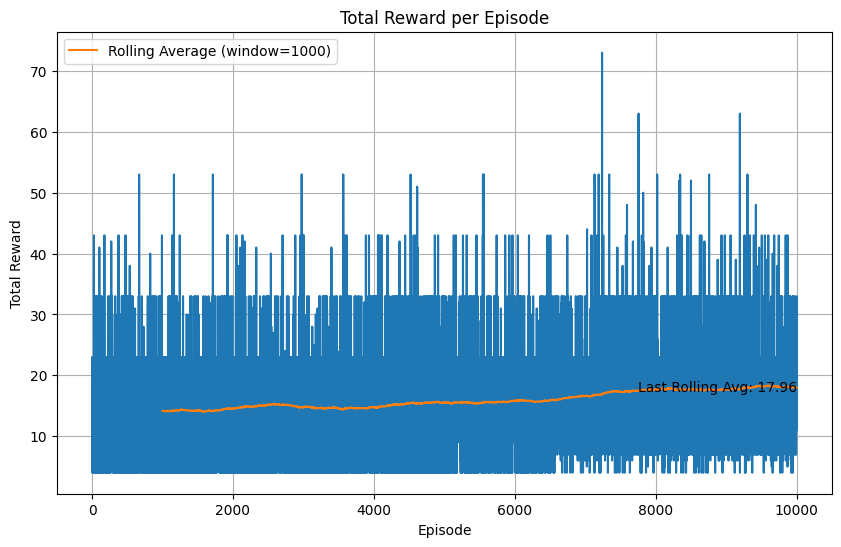

In [214]:
epsilons_decays = [.99999,.9999,.999,.99,.9]

for decay in epsilons_decays :

  policy, Q , rewards,len_episodes = mc_control(env,
                                 num_episodes=10000,
                                 alpha=0.02,
                                 gamma=0.85,
                                 eps_start=0.7,
                                 eps_decay=decay,
                                 eps_min=0.05,
                                max_steps = 10000)
  print("Epsilon Decay of :",decay )
  reward_plot(rewards)

### Gamma

 31%|███       | 3051/10000 [00:16<00:36, 188.52it/s]


Gamma of : 1


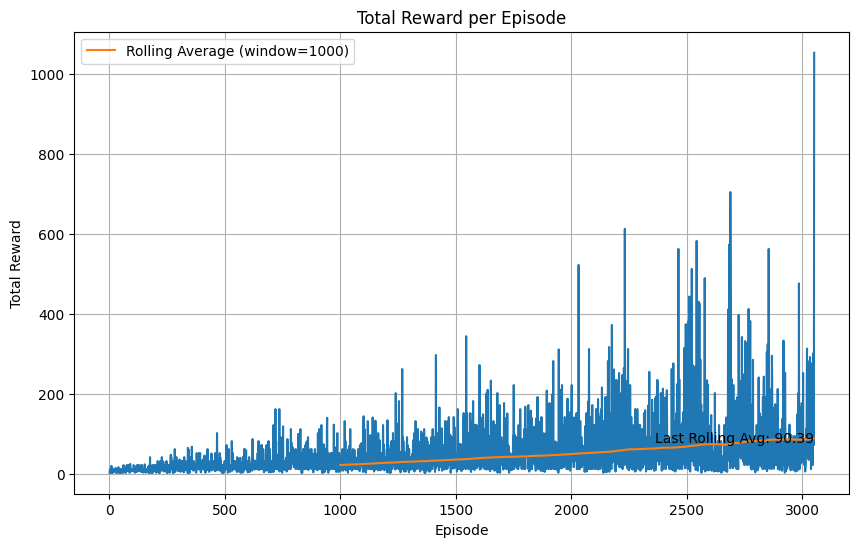

 32%|███▏      | 3220/10000 [00:29<01:01, 110.00it/s]


Gamma of : 0.8


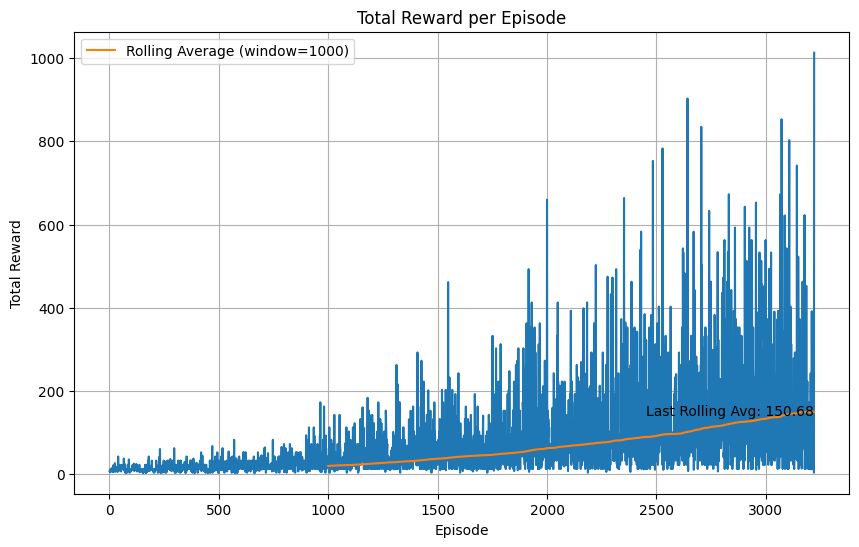

 33%|███▎      | 3251/10000 [00:23<00:48, 137.82it/s]


Gamma of : 0.75


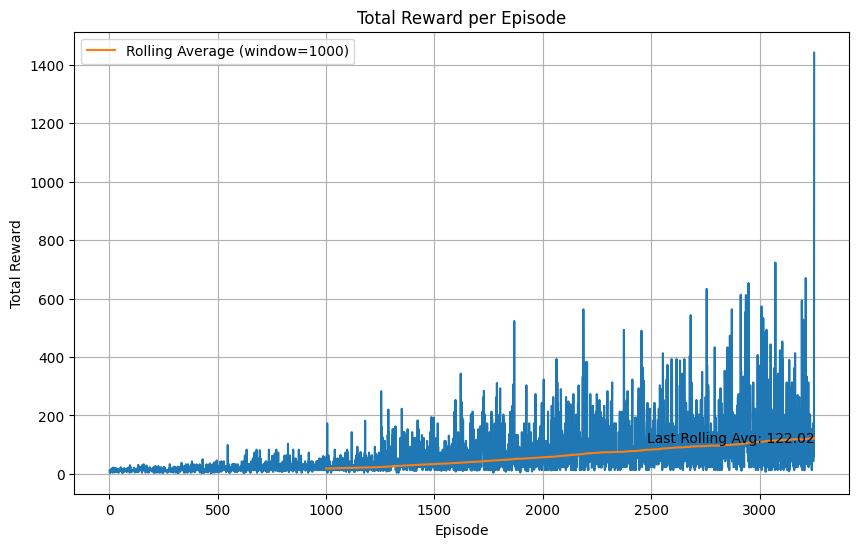

 69%|██████▊   | 6874/10000 [01:12<00:32, 95.46it/s]


Gamma of : 0.6


100%|██████████| 10000/10000 [01:09<00:00, 143.91it/s]


Gamma of : 0.5


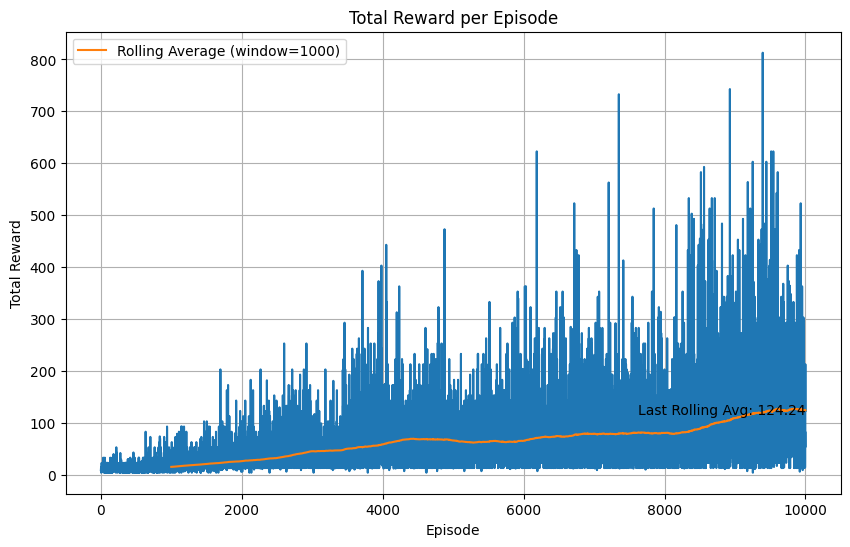

100%|██████████| 10000/10000 [01:11<00:00, 139.53it/s]


Gamma of : 0.4


In [215]:
gammas = [1,0.8,0.75,0.6,0.5,0.4]

for gamma in gammas :

  policy, Q , rewards,len_episodes = mc_control(env,
                                 num_episodes=10000,
                                 alpha=0.1,
                                 gamma=gamma,
                                 eps_start=0.7,
                                 eps_decay=0.999,
                                 eps_min=0.05,
                                max_steps = 1000)
  print("Gamma of :",gamma )
  reward_plot(rewards)

### Alphas

 32%|███▏      | 3185/10000 [00:23<00:51, 133.12it/s]


Alpha of : 0.3


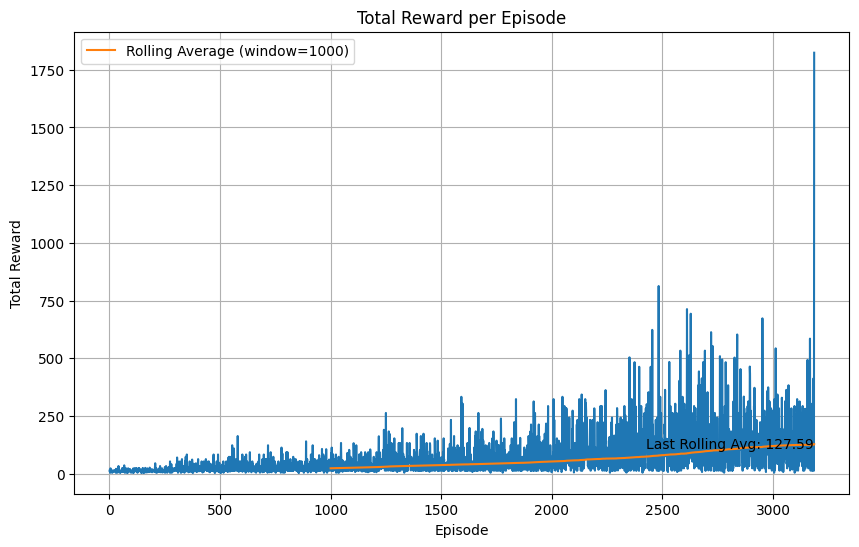

 32%|███▏      | 3183/10000 [00:23<00:51, 132.76it/s]


Alpha of : 0.2


 31%|███       | 3079/10000 [00:21<00:47, 146.44it/s]


Alpha of : 0.1


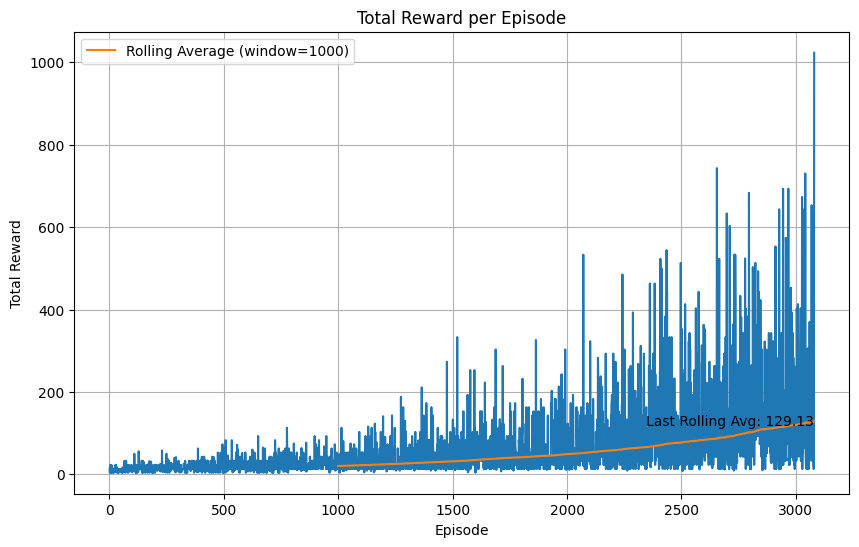

 79%|███████▊  | 7854/10000 [01:01<00:16, 126.77it/s]


Alpha of : 0.05


100%|██████████| 10000/10000 [00:26<00:00, 378.25it/s]


Alpha of : 0.01


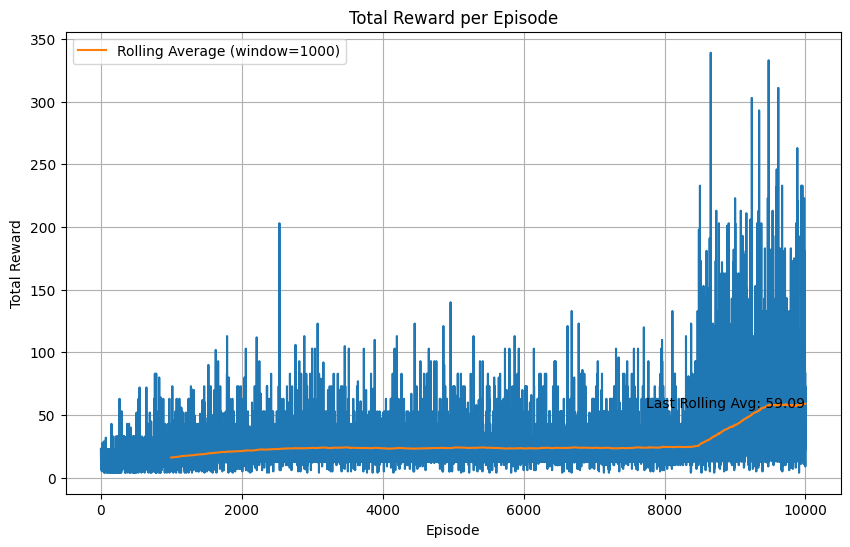

In [216]:
alphas = [0.3,0.2,0.1,0.05,0.01]

for alpha in alphas :

  policy, Q , rewards,len_episodes = mc_control(env,
                                 num_episodes=10000,
                                 alpha=alpha,
                                 gamma=0.75,
                                 eps_start=0.7,
                                 eps_decay=0.999,
                                 eps_min=0.05,
                                max_steps = 1000)
  print("Alpha of :",alpha )
  reward_plot(rewards)

## Final Hyperparameters

In [217]:
policy, Q , rewards,len_episodes = mc_control(env,
                                 num_episodes=20000,
                                 alpha=0.3,
                                 gamma=0.8,
                                 eps_start=0.7,
                                 eps_decay=0.999,
                                 eps_min=0.05,
                                max_steps = 5000)

reward_plot(rewards)

100%|██████████| 20000/20000 [05:07<00:00, 64.98it/s]


We can see that only 3k epsisodes are enough.

# Length of episode vs number of episodes

In our case, sum of cumulative reward and score of the flappy bird are relatively the same : we earn 1 reward for each action where the bird doesn't die, and the score is +1 when we go through a door. The plots should thus relatively be the same.

Now, our policy is fixed, according to the best hyperparameters we found :

In [12]:
policy, Q , rewards,len_episodes = mc_control(env,
                                 num_episodes=4000,
                                 alpha=0.3,
                                 gamma=0.8,
                                 eps_start=0.7,
                                 eps_decay=0.999,
                                 eps_min=0.05,
                                max_steps = 5000)

100%|██████████| 4000/4000 [00:39<00:00, 102.22it/s]


## Length Episode vs Episode plot function

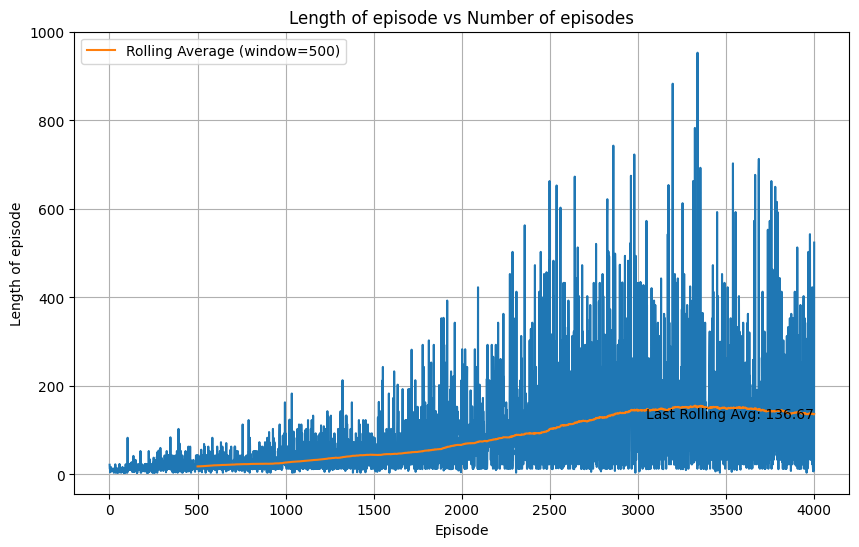

In [13]:
def len_episode_plot(len_episodes):
    plt.figure(figsize = (10,6))
    plt.plot(np.arange(1, len(len_episodes) + 1), len_episodes)

    # Calculate rolling average
    rolling_average = pd.Series(len_episodes).rolling(window=500).mean()

    # Plot the rolling average
    plt.plot(np.arange(1, len(len_episodes) + 1), rolling_average, label='Rolling Average (window=500)')

    last_rolling_avg = rolling_average.iloc[-1]
    plt.text(len(len_episodes), last_rolling_avg, f'Last Rolling Avg: {last_rolling_avg:.2f}', ha='right', va='center')

    plt.xlabel('Episode')
    plt.ylabel('Length of episode')
    plt.title('Length of episode vs Number of episodes')
    plt.grid(True)
    plt.legend()
    plt.show()

len_episode_plot(len_episodes)

## Playing Game with the best trained agent

We put `sleep_time=0`, to see how far our bird can fly.

In [14]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
play_game(env, policy,num_frames=2000,sleep_time=0)

Text Flappy Bird!
Score: 199
----------------------
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[                    ]
[                    ]
[                    ]
[      @             ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=3,dy=1)


The bird never dies and goes to a score of 200! We found one of our best agents !

# Q-values and Policy Function plot

Now, let's analyse the Q values and policy function with plots.

## Plotting  state values

In our project, we can plot 2 plots : Q values for the action "idle" and an onther for "flap".

In [15]:
def plot_state_values(q, x_state_space_range=(0,14), y_state_space_range=(-11,11)):

  """ Plots in 3D the Q values
  q_values [dict]"""

  # Extract states and corresponding Q values
  states = list(q.keys())

  # Function to get Z value
  def get_Z(x, y, action):

      if (x, y) in q:
          return q[(x, y)][action]
      else:
          return 0

  def get_figure(action, ax):
        x_range = np.arange(*x_state_space_range)
        y_range = np.arange(*y_state_space_range)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([[get_Z(x, y, action) for x in x_range] for y in y_range])

        surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, alpha=0.9)
        ax.set_xlabel('Distance X')
        ax.set_ylabel('Distance Y')
        ax.set_zlabel('Q Value')

  # Create figure and subplots
  fig = plt.figure(figsize=(20, 20))
  ax1 = fig.add_subplot(211, projection='3d')
  ax1.set_title('Action: Idle')
  get_figure(0, ax1)  # 0 represents 'idle' action
  ax1.view_init(elev=50, azim=140)

  ax2 = fig.add_subplot(212, projection='3d')
  ax2.set_title('Action: Flap')
  get_figure(1, ax2)  # 1 represents 'flap' action
  ax2.view_init(elev=50, azim=140)

  plt.show()

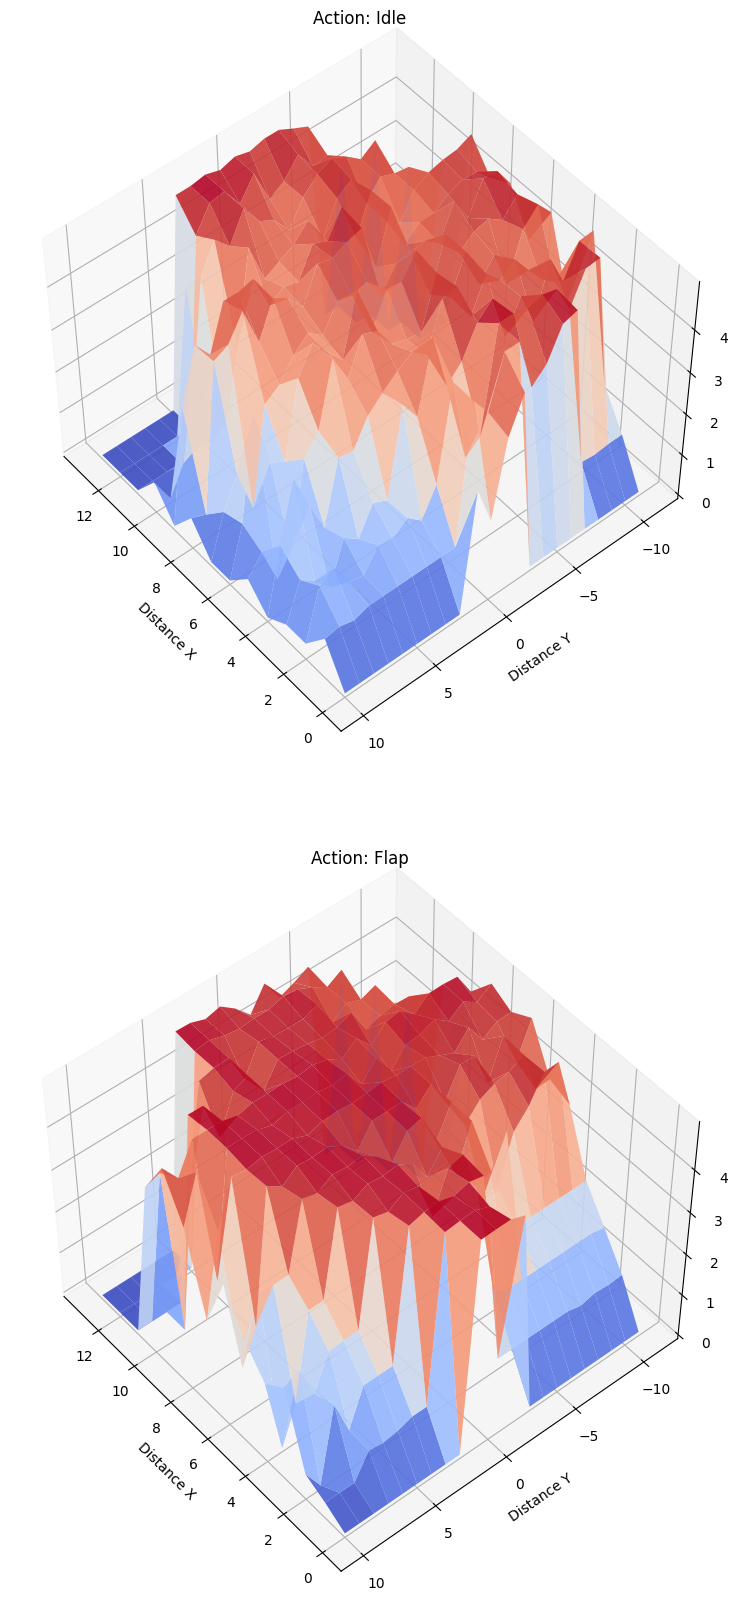

In [16]:
plot_state_values(Q)

We see that the Q values are higher for y distance aroung 0 and for long x distance.
But what really interest us is the comparison between those Q values for each action, that is which policy do we pick .

## Plotting the Policy function

In [17]:
def plot_policy(policy, x_state_space_range=(0,14), y_state_space_range=(-11,11)):

  # Function to get Z value
  def get_Z(x, y):
    if (x, y) in policy:
        return policy[(x, y)]
    else:
        return 0

  def get_figure(ax):
      x_range = np.arange(x_state_space_range[0],x_state_space_range[1])
      y_range = np.arange(y_state_space_range[0],y_state_space_range[1])
      X, Y = np.meshgrid(x_range, y_range)

      Z = np.array([[get_Z(x, y) for x in x_range] for y in y_range])

      surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2_r', 2), vmin=0, vmax=1, extent=[x_state_space_range[0] - 0.5, x_state_space_range[1] + 0.5, y_state_space_range[0] - 0.5, y_state_space_range[1] + 0.5])
      plt.xticks(x_range)
      plt.yticks(y_range)
      ax.set_xlabel('Distance X')
      ax.set_ylabel('Distance Y')
      ax.grid(color='w', linestyle='-', linewidth=1)
      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="5%", pad=0.1)
      cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
      cbar.ax.set_yticklabels(['0 (Idle)','1 (Flap)'])

  # Create figure and subplots
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111)
  ax.set_title('Policy for Flappy Bird')
  get_figure(ax)

  plt.show()

In [18]:
plot_policy(policy)

As expected :
1. For x_dist = 0 we flap around the center of the pipe (y = 0)
2. we often flap in a safe zone : X distance bewteen 1 and 11
3. If we flap for y_dist > 2 (that is in a the highest zone of the screen) we expected the x_dist for be > 8, a little bit far from the pipe.

# Sarsa(λ) agent

We can define another agent : a variation of Sarsa that in an online, incremental algorithm that updates its estimates after each step.

We need to maintain an **eligibility trace** for each state-action pair. The eligibility trace determines how much each state-action pair should contribute to the update of the action-value estimate. The lambda parameter controls the decay rate of the eligibility trace.

With Sarsa($\lambda$) , the updates are:

\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha [r_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)]
\end{equation}

\begin{equation}
e_t(s_t,a_t) \leftarrow \gamma \lambda e_{t-1}(s_t,a_t) + 1
\end{equation}

\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha e_t(s_t,a_t) [r_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)]
\end{equation}


The eligibility trace vector is updated based on the state-action pairs that are visited and the TD error.
The eligibility trace vector is used to determine which state-action pairs should be updated and by how much.

## Agent class

In [24]:
num_states=2
num_actions=22*11

In [25]:
class SarsaLambdaAgent():

    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states in which the agent can be,
            num_actions (int): The number of actions the agent can make,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
            lambda_val (float): The lambda parameter for eligibility trace decay,
        }

        """

        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.lambda_val = agent_init_info["lambda_val"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])

        # Create an array for action-value estimates and initialize it to zero.

        self.q = defaultdict(lambda: np.zeros(self.num_actions)) # initialize a dictionnary where each state will have an array of size 2 associated.



    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the initial state from the environment's function.

        Returns:
            action (int): the first action the agent takes.
        """
        # Create an array for eligibility traces and initialize it to zero.
        self.eligibility_trace = defaultdict(lambda: np.zeros(self.num_actions)) #same dimension as q

        # Choose action using epsilon greedy

        current_q = self.q[state] #array of the qvalues in the q dict for this particular state

        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        self.prev_state = state
        self.prev_action = action

        # Initialize the eligibility trace for the chosen state-action pair to 1.
        self.eligibility_trace[self.prev_state][self.prev_action] = 1

        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state] #array of the qvalues in the q dict for this particular state
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)


        ## PERFORM AN UPDATE ##

        # Calculate the TD error (td_error) (self.prev_state and self.prev_action are stored from the previous iteration)

        #next_q = self.q.get((state, action), 0)
        next_q = self.q[state][action]
        td_error = reward + self.discount * next_q - self.q[self.prev_state][self.prev_action]
        #td_error = reward + self.discount * next_q - self.q.get((self.prev_state, self.prev_action), 0)

        # Update the eligibility trace for all state-action pairs
        for s, actions in self.eligibility_trace.items():
            for a, trace in enumerate(actions):
                self.eligibility_trace[s][a] *= self.discount * self.lambda_val

        # Update the eligibility trace for the chosen state-action pair
        self.eligibility_trace[self.prev_state][self.prev_action] += 1

        # Update the Q-values using the TD error and eligibility trace
        for s, actions in self.q.items():
            for a, q_value in enumerate(actions):
                self.q[s][a] += self.step_size * td_error * self.eligibility_trace[s][a]


        # Update the previous state and action
        self.prev_state = state
        self.prev_action = action


        return action

    def agent_end(self, reward):
        """Run when the agent terminates.

        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update

        self.q[self.prev_state][self.prev_action] += self.step_size * (reward - self.q[self.prev_state][self.prev_action])

    def map_policy(self):
      ''' Mapping of the q values to a final policy'''

      self.policy = dict()

      for state, _ in self.q.items(): #to run when the agent has been trained
        self.policy[state]=self.argmax(self.q[state])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values given when computing the epsilon greedy policy. eg [0,0] if no q values and 2 actions
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


## Tests

Let's see if our methods work :

In [26]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(14), Discrete(22, start=-11))


In [27]:
agent_info = {"num_actions": env.action_space.n,
              "num_states": 14*22,
              "epsilon": 0.1,
              "step_size": 0.1,
              "discount": 1.0,
              "lambda_val": 0.5,
              "seed": 0}

### Agent init

In [28]:
sarsa_agent = SarsaLambdaAgent()
sarsa_agent.agent_init(agent_info)
print("Initial q")
print(sarsa_agent.q) #q has no values here as no updates have been done
print('\n')
print("eligibility_trace")
#print(sarsa_agent.eligibility_trace)

Initial q
defaultdict(<function SarsaLambdaAgent.agent_init.<locals>.<lambda> at 0x7c6e243788b0>, {})


eligibility_trace


### Agent start

In [29]:
initial_state = env.reset()[0]
print("initial_state", initial_state)
action = sarsa_agent.agent_start(initial_state)
print("Action after start", action)

initial_state (13, 3)
Action after start 1


In [30]:
sarsa_agent.q

defaultdict(<function __main__.SarsaLambdaAgent.agent_init.<locals>.<lambda>()>,
            {(13, 3): array([0., 0.])})

In [31]:
sarsa_agent.eligibility_trace

defaultdict(<function __main__.SarsaLambdaAgent.agent_start.<locals>.<lambda>()>,
            {(13, 3): array([0., 1.])})

### Agent step

In [32]:
print("Previous Q values")
print(sarsa_agent.q)
sarsa_agent.agent_step(state = (1,2),reward = 1)

print("Updated Q values")
print(sarsa_agent.q)

Previous Q values
defaultdict(<function SarsaLambdaAgent.agent_init.<locals>.<lambda> at 0x7c6e243788b0>, {(13, 3): array([0., 0.])})
Updated Q values
defaultdict(<function SarsaLambdaAgent.agent_init.<locals>.<lambda> at 0x7c6e243788b0>, {(13, 3): array([0.  , 0.15]), (1, 2): array([0., 0.])})


### Agent end

In [33]:
print("Previous Q values")
print(sarsa_agent.q)

sarsa_agent.agent_end(reward = 2)

print("Updated Q values")
print(sarsa_agent.q)

Previous Q values
defaultdict(<function SarsaLambdaAgent.agent_init.<locals>.<lambda> at 0x7c6e243788b0>, {(13, 3): array([0.  , 0.15]), (1, 2): array([0., 0.])})
Updated Q values
defaultdict(<function SarsaLambdaAgent.agent_init.<locals>.<lambda> at 0x7c6e243788b0>, {(13, 3): array([0.  , 0.15]), (1, 2): array([0. , 0.2])})


### Map Policy

In [34]:
print(sarsa_agent.q)

print("Final Policy")
sarsa_agent.map_policy()
sarsa_agent.policy

defaultdict(<function SarsaLambdaAgent.agent_init.<locals>.<lambda> at 0x7c6e243788b0>, {(13, 3): array([0.  , 0.15]), (1, 2): array([0. , 0.2])})
Final Policy


{(13, 3): 1, (1, 2): 1}

## Making the agent learn

Let's define a function that train the agent. It returns the agent instance so that we can access its policy and q values.

In [39]:
def train_sarsa(env,epsilon=0.1, step_size=0.1,discount=0.99,lambda_val=0.9,seed=0,num_episodes=1000,max_steps_per_episode=1000):
  """ Function that trains a sarsa agent for a given environment
  Output:
   total_sum_rewards [list] : Sum of cumulative reward for each episodes
   len_episodes [list] : length of each episode
   sarsa_agent[SarsaAgent] : trained agent"""

  agent_info={
      "num_states": 14*22,
      "num_actions": env.action_space.n,
      "epsilon": epsilon,
      "step_size":step_size ,
      "discount":discount ,
      "lambda_val":lambda_val ,
      'seed':seed
  }
  sarsa_agent = SarsaLambdaAgent()
  sarsa_agent.agent_init(agent_info)

  total_sum_rewards=[]
  len_episodes=[]

  for episode in tqdm(range(num_episodes)):

      episode_reward = []

      # Reset the environment to start a new episode
      observation = env.reset()
      state  = observation[0]

      action = sarsa_agent.agent_start(state) #first action

      for step in range(max_steps_per_episode):

          # Take action and observe the next state and reward
          next_state, reward, done,_, info = env.step(action)

          # Choose the next action using the agent's policy
          next_action = sarsa_agent.agent_step(reward, next_state)

          # Update current state and action
          state = next_state
          action = next_action

          episode_reward.append(reward)

          # Check if the episode is done
          if done:
              break

      total_sum_rewards.append(sum(episode_reward))
      len_episodes.append(len(episode_reward))

      sarsa_agent.agent_end(reward)

  sarsa_agent.map_policy()

  return total_sum_rewards, len_episodes,sarsa_agent


In [40]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
total_sum_rewards, len_episodes,trained_agent=train_sarsa(env=env,
            epsilon=0.1,
            step_size=0.1,
            discount=0.99,
            lambda_val=0.9,
            seed=0,
            num_episodes=1000,
            max_steps_per_episode=1000)

100%|██████████| 1000/1000 [00:33<00:00, 29.74it/s]


After this, the agent learned.

## Playing Game

We can see how our bird acts here :

## Play Game function for Sarsa Agent

In [41]:
from IPython.display import clear_output

def play_game_agent(env, agent, num_frames=100, sleep_time = 0.1):
  """Function that plays the game for a certain number of frames
  num_frames[int] : number of frames that will be displayed """


  obs = env.reset() #initial observation eg ((13, -5), {'score': 0, 'player': [6, 7], 'distance': 13.92838827718412})
  state = obs[0] #initial state. eg (13, -5)

  # iterate
  for _ in range(num_frames):
      print("state", state)
      action = agent.policy[state]
      print("action", action)

      # Appy action and return new observation of the environment
      state, reward, done, _, info = env.step(action)

      # Clear the output cell
      clear_output(wait=True)

      # Render the game
      sys.stdout.write(env.render())
      time.sleep(sleep_time)  # FPS
      sys.stdout.flush()  # Flush the output buffer
      # If player is dead break
      if done:
          break
  env.close()

In [42]:
play_game_agent(env, trained_agent)

Text Flappy Bird!
Score: 1
----------------------
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |             ]
[      |             ]
[      |             ]
[      |             ]
[      |         |   ]
[                |   ]
[                |   ]
[                |   ]
[                |   ]
[     *|         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=0,dy=2)


The bird isn't very successful ! Let's find the best hyperparameters.

## Hyperparameters tuning

### Epsilon

100%|██████████| 1000/1000 [00:40<00:00, 24.85it/s]


Epsilon value: 0.05


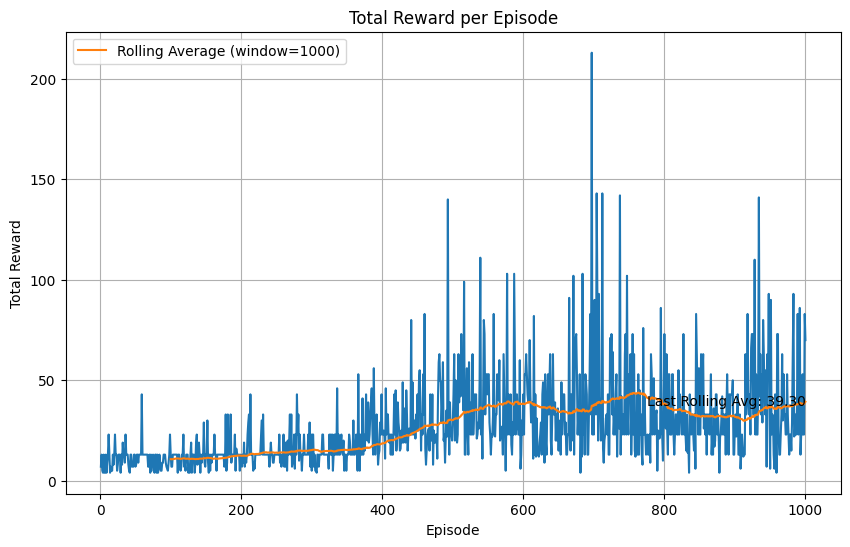

100%|██████████| 1000/1000 [00:46<00:00, 21.54it/s]


Epsilon value: 0.1


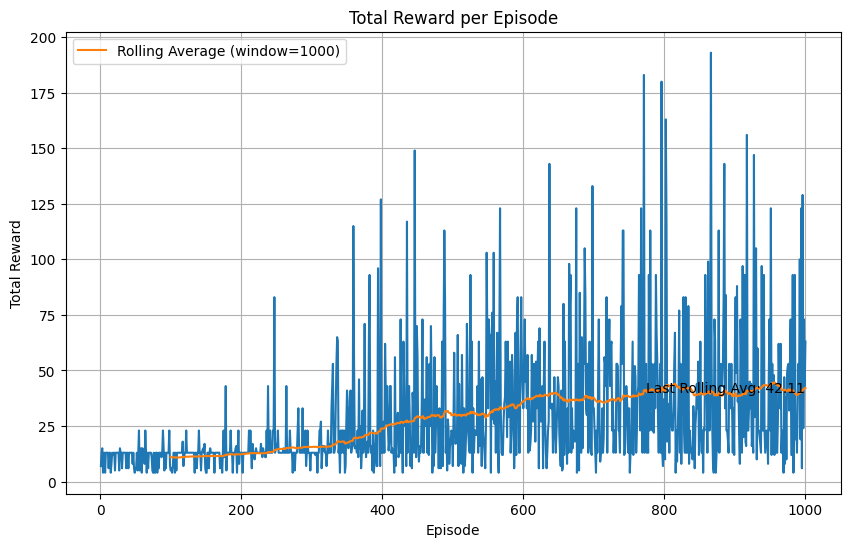

100%|██████████| 1000/1000 [00:45<00:00, 22.12it/s]


Epsilon value: 0.2


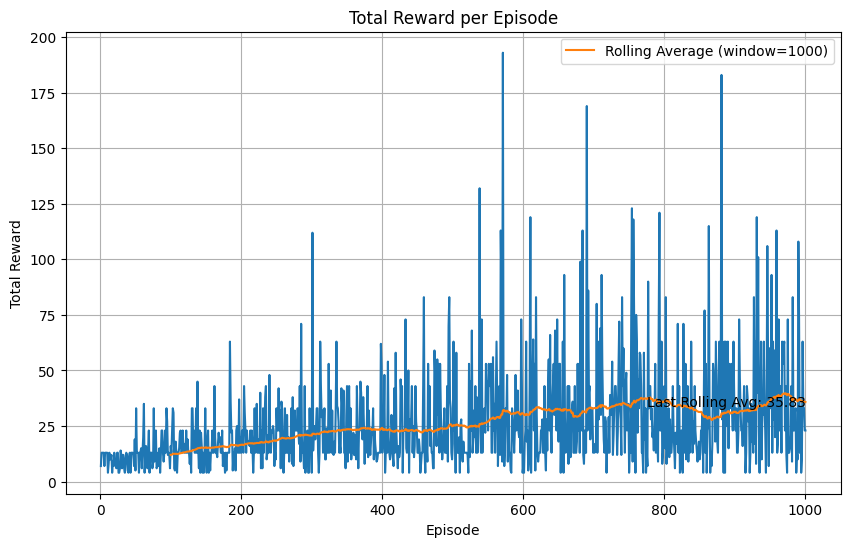

100%|██████████| 1000/1000 [00:39<00:00, 25.60it/s]


Epsilon value: 0.3


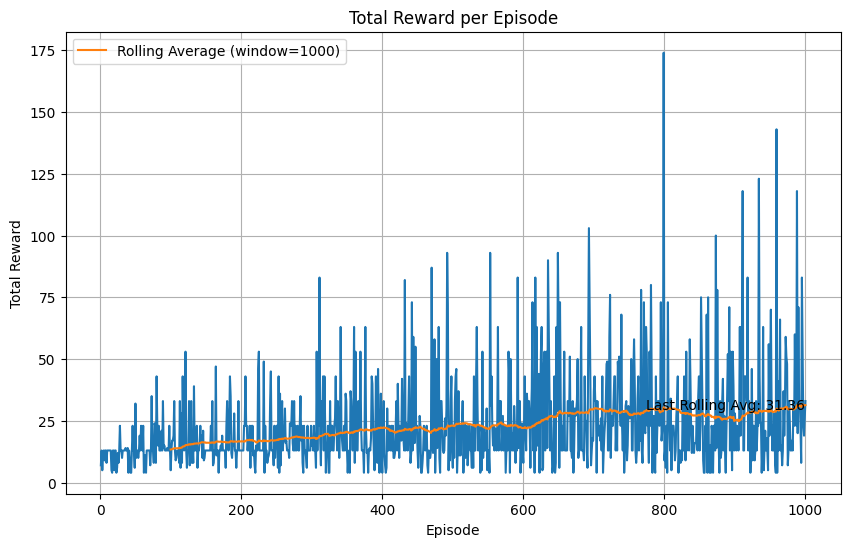

100%|██████████| 1000/1000 [00:34<00:00, 28.88it/s]


Epsilon value: 0.4


100%|██████████| 1000/1000 [00:30<00:00, 32.57it/s]


Epsilon value: 0.5


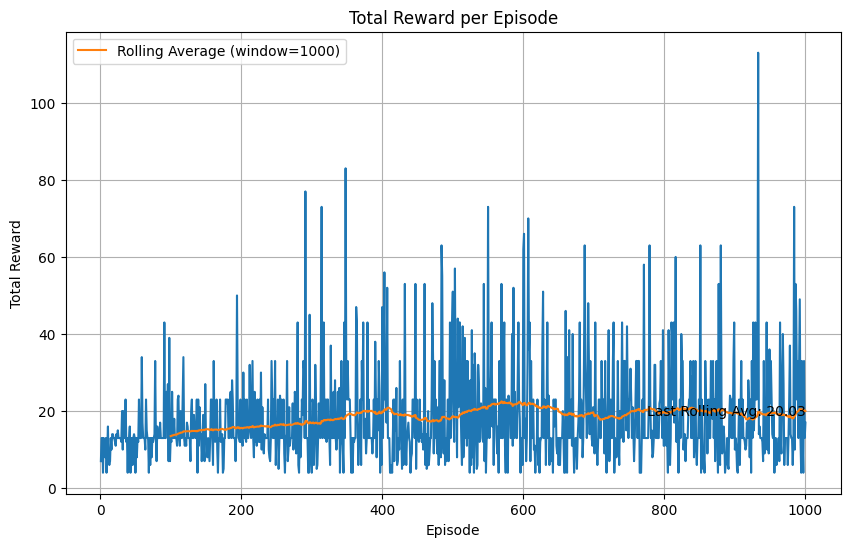

In [241]:
epsilons = [0.05,0.1,0.2,0.3,0.4,0.5]

for epsilon in epsilons :

  total_sum_rewards, len_episodes,trained_agent=train_sarsa(env=env,
              epsilon=epsilon,
              step_size=0.3,
              discount=0.99,
              lambda_val=0.9,
              seed=0,
              num_episodes=1000,
              max_steps_per_episode=300)

  print("Epsilon value:", epsilon)

  reward_plot(total_sum_rewards,rolling_window = 100)

### Step Size

100%|██████████| 1000/1000 [00:15<00:00, 62.85it/s]


Step Sizes: 0.05


100%|██████████| 1000/1000 [00:21<00:00, 46.92it/s]


Step Sizes: 0.1


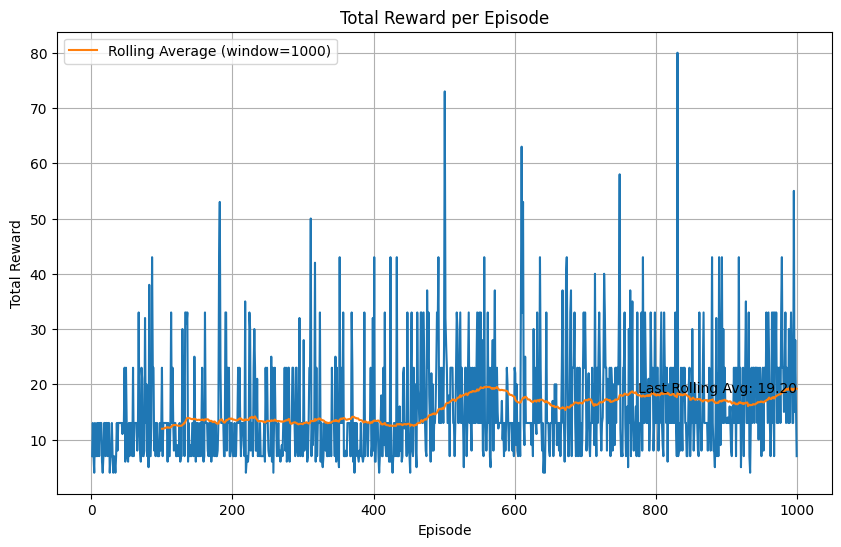

100%|██████████| 1000/1000 [00:59<00:00, 16.86it/s]


Step Sizes: 0.2


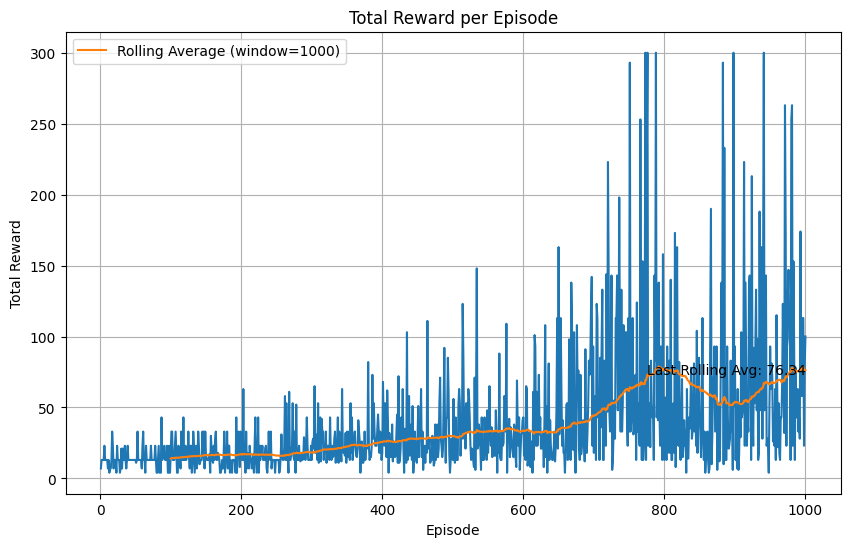

100%|██████████| 1000/1000 [00:48<00:00, 20.53it/s]


Step Sizes: 0.3


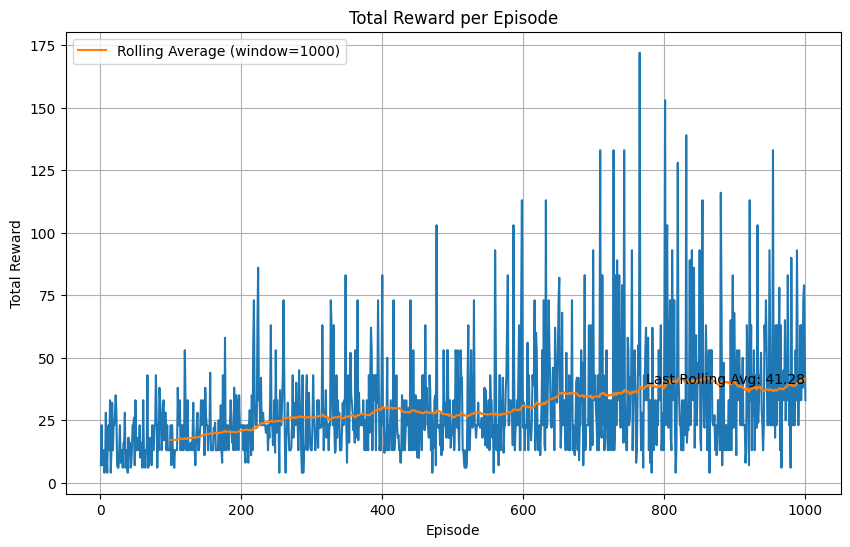

100%|██████████| 1000/1000 [00:58<00:00, 16.98it/s]


Step Sizes: 0.4


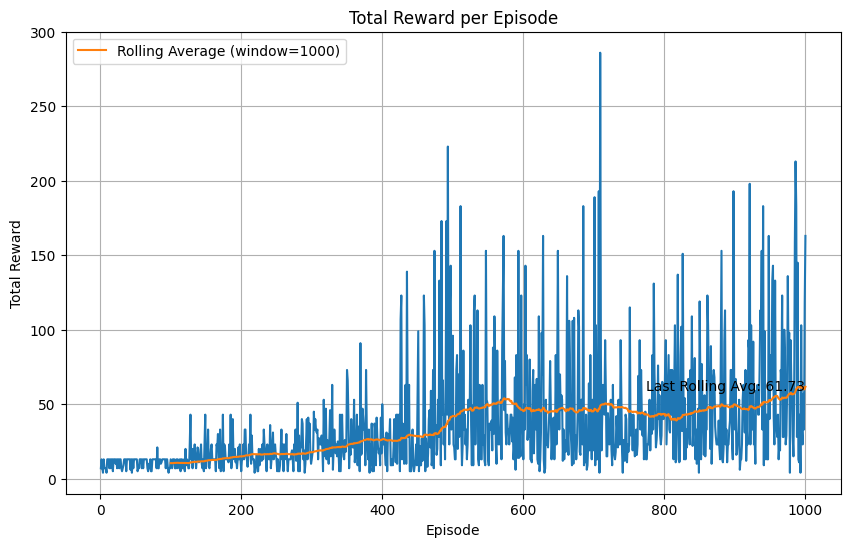

100%|██████████| 1000/1000 [01:12<00:00, 13.79it/s]


Step Sizes: 0.5


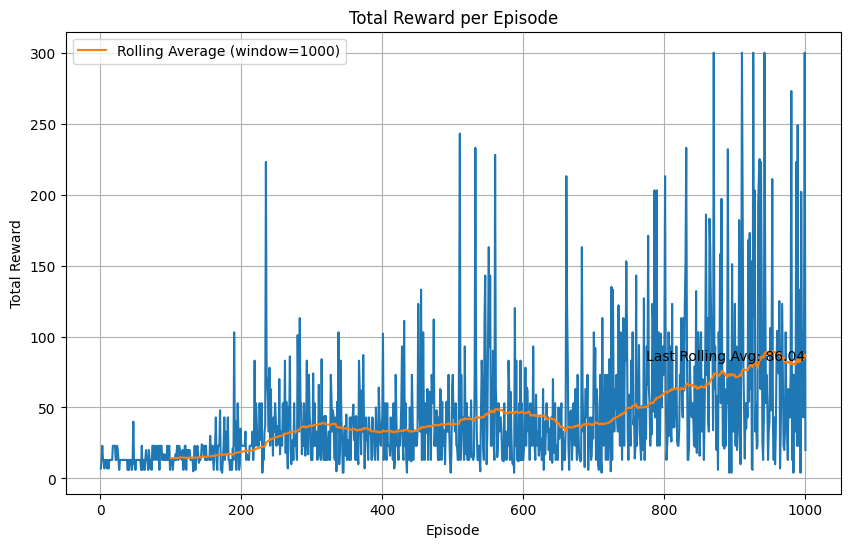

In [242]:
step_sizes = [0.05,0.1,0.2,0.3,0.4,0.5]

for step_size in step_sizes :

  total_sum_rewards, len_episodes,trained_agent=train_sarsa(env=env,
              epsilon=0.05,
              step_size=step_size,
              discount=0.99,
              lambda_val=0.9,
              seed=0,
              num_episodes=1000,
              max_steps_per_episode=300)

  print("Step Sizes:", step_size)

  reward_plot(total_sum_rewards,rolling_window = 100)

### Discounts

100%|██████████| 1000/1000 [00:27<00:00, 36.78it/s]


Discount: 0.9


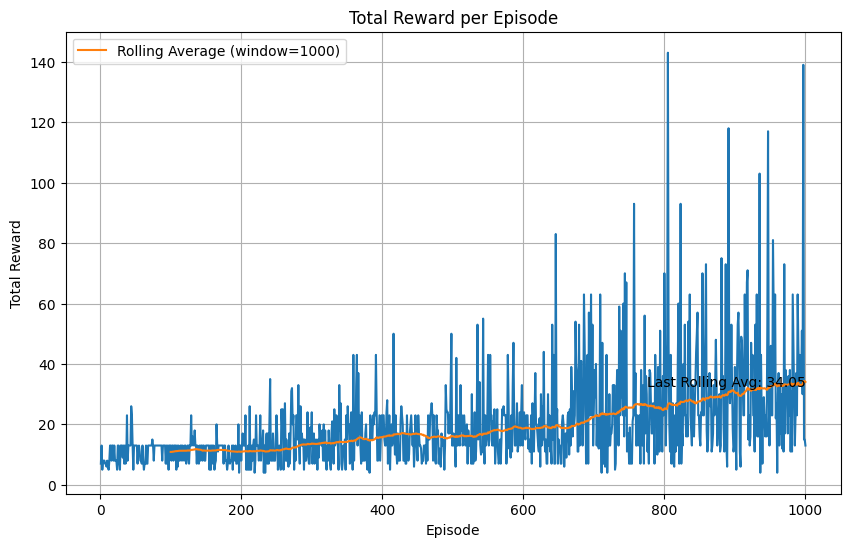

100%|██████████| 1000/1000 [00:46<00:00, 21.69it/s]


Discount: 0.95


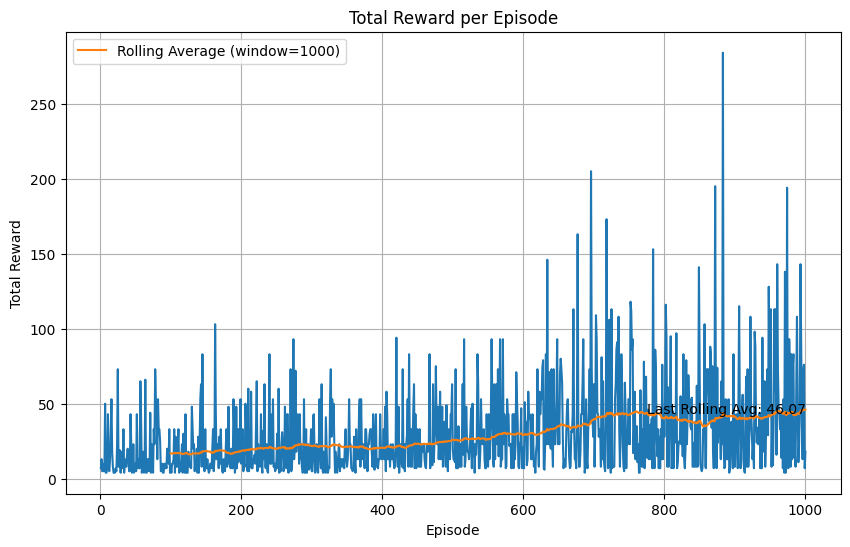

100%|██████████| 1000/1000 [00:29<00:00, 33.65it/s]


Discount: 0.97


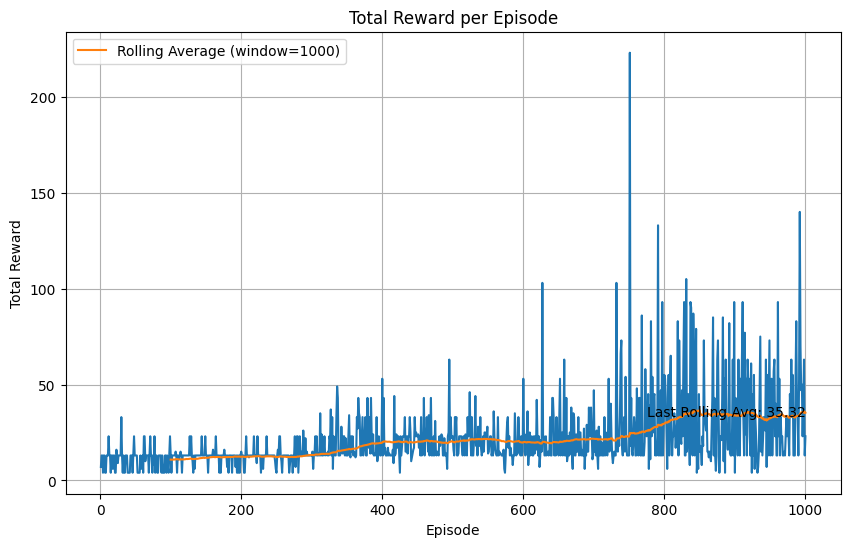

100%|██████████| 1000/1000 [00:24<00:00, 40.18it/s]


Discount: 0.99


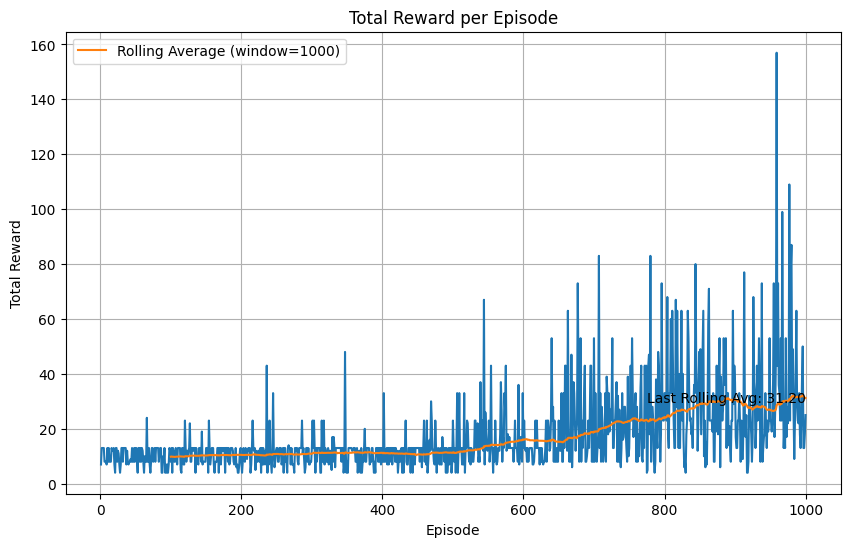

100%|██████████| 1000/1000 [00:18<00:00, 54.23it/s]


Discount: 0.999


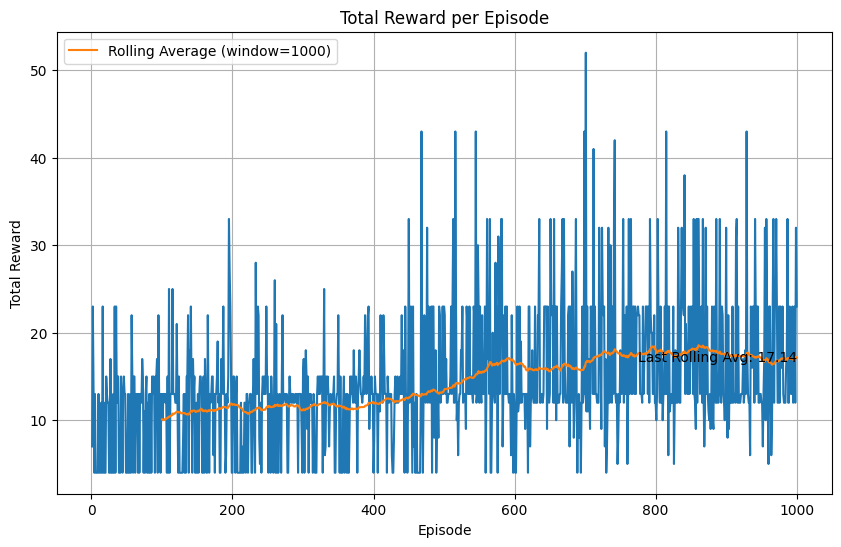

In [243]:
discounts = [0.9,0.95,0.97,0.99,0.999]

for discount in discounts :

  total_sum_rewards, len_episodes,trained_agent=train_sarsa(env=env,
              epsilon=0.05,
              step_size=0.2,
              discount=discount,
              lambda_val=0.9,
              seed=0,
              num_episodes=1000,
              max_steps_per_episode=300)

  print("Discount:", discount)

  reward_plot(total_sum_rewards,rolling_window = 100)

### Lambda

100%|██████████| 1000/1000 [00:10<00:00, 96.25it/s]


Lambda: 0.5


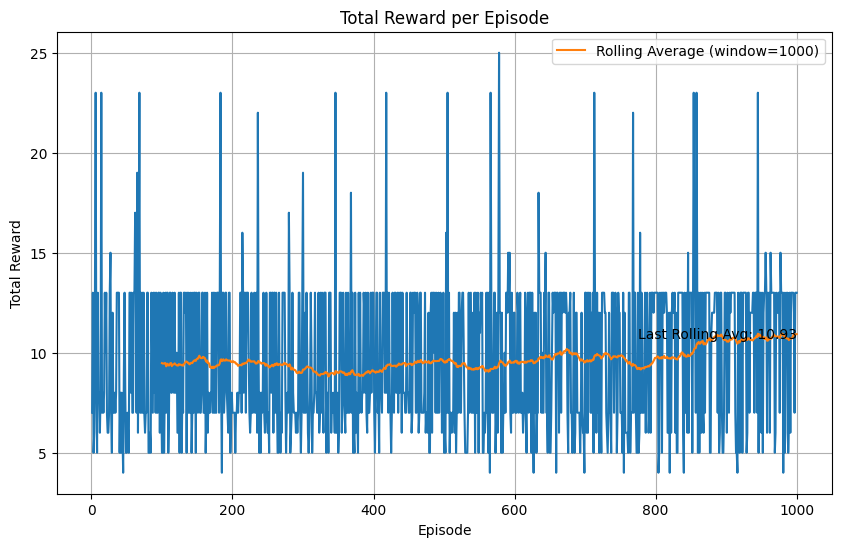

100%|██████████| 1000/1000 [00:19<00:00, 50.43it/s]


Lambda: 0.6


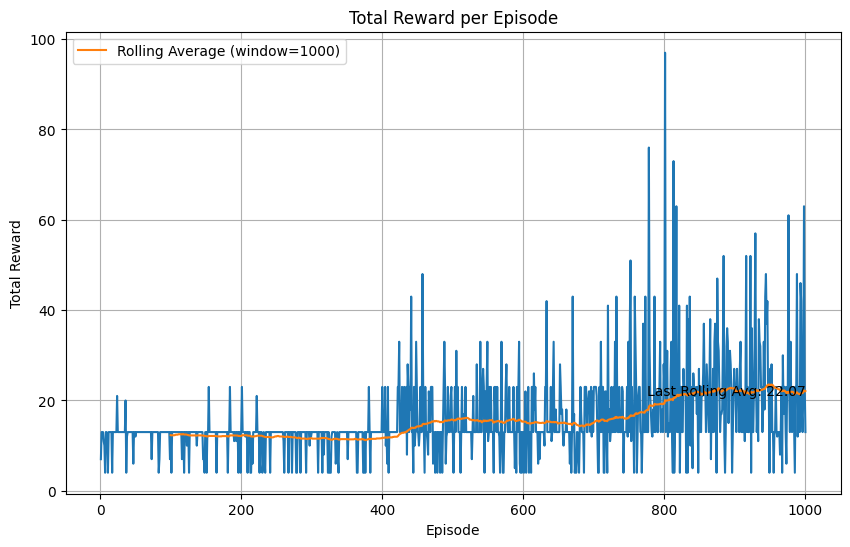

100%|██████████| 1000/1000 [00:11<00:00, 85.13it/s]


Lambda: 0.7


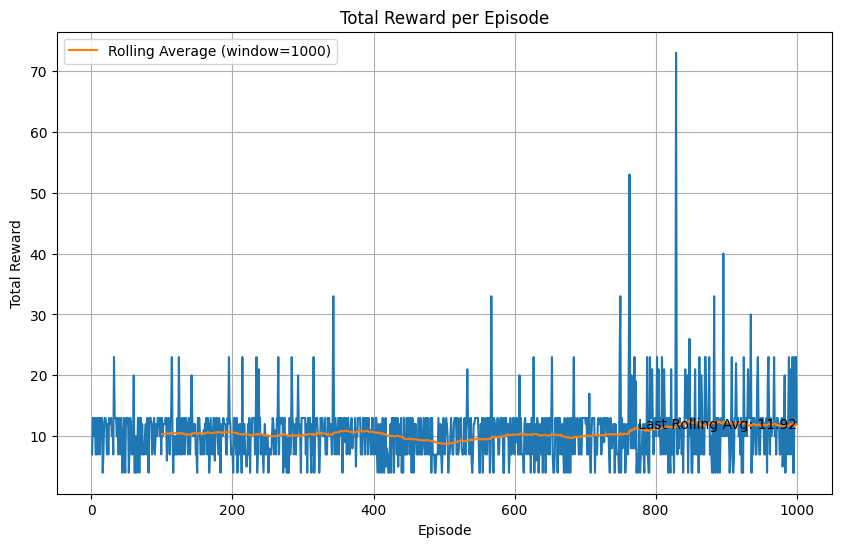

100%|██████████| 1000/1000 [00:16<00:00, 61.80it/s]


Lambda: 0.8


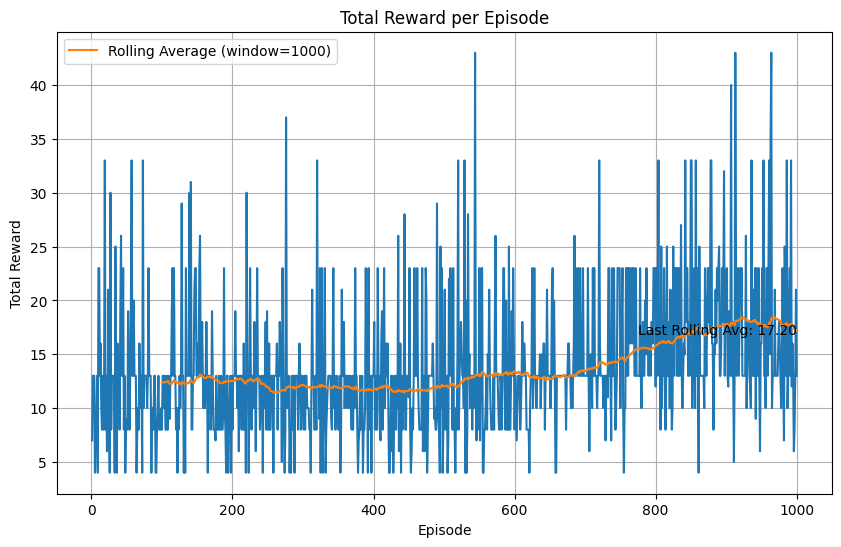

100%|██████████| 1000/1000 [00:31<00:00, 32.16it/s]


Lambda: 0.9


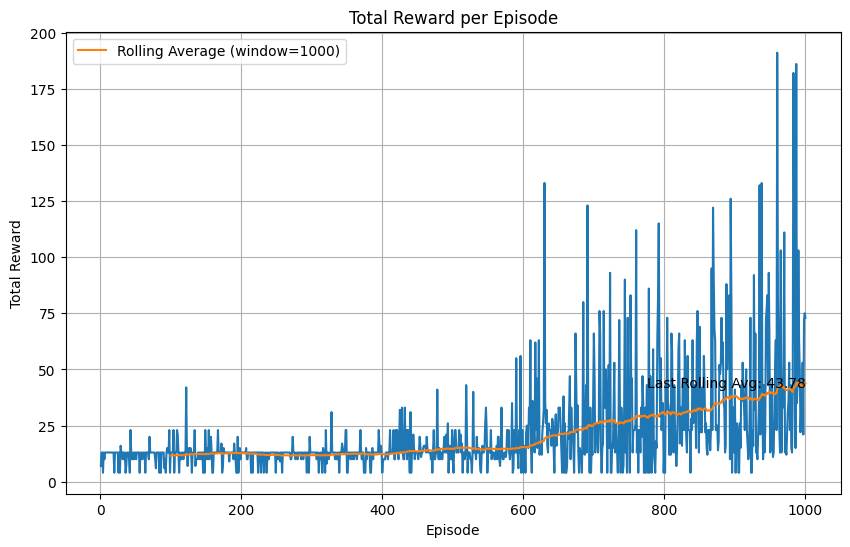

In [244]:
lambda_vals = [0.5,0.6,0.7,0.8,0.9]

for lambda_val in lambda_vals :

  total_sum_rewards, len_episodes,trained_agent=train_sarsa(env=env,
              epsilon=0.05,
              step_size=0.2,
              discount=0.9,
              lambda_val=lambda_val,
              seed=0,
              num_episodes=1000,
              max_steps_per_episode=300)

  print("Lambda:", lambda_val)

  reward_plot(total_sum_rewards,rolling_window = 100)

## Training our best agent

In [54]:
total_sum_rewards, len_episodes,trained_agent=train_sarsa(env=env,
              epsilon=0.05,
              step_size=0.3,
              discount=0.99,
              lambda_val=0.9,
              num_episodes=5000,
              max_steps_per_episode=1000)

100%|██████████| 5000/5000 [10:54<00:00,  7.64it/s]


### Cumulative Reward Plot

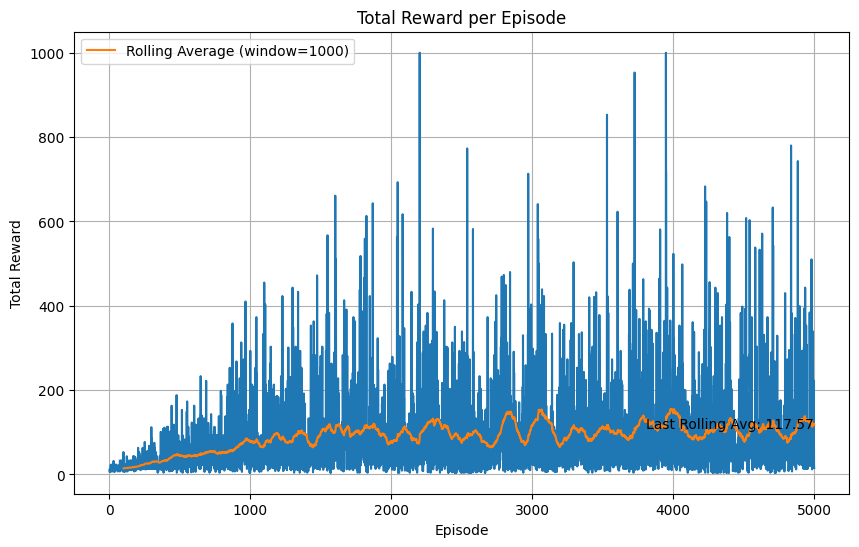

In [45]:
reward_plot(total_sum_rewards,rolling_window = 100)

## Length of episodes

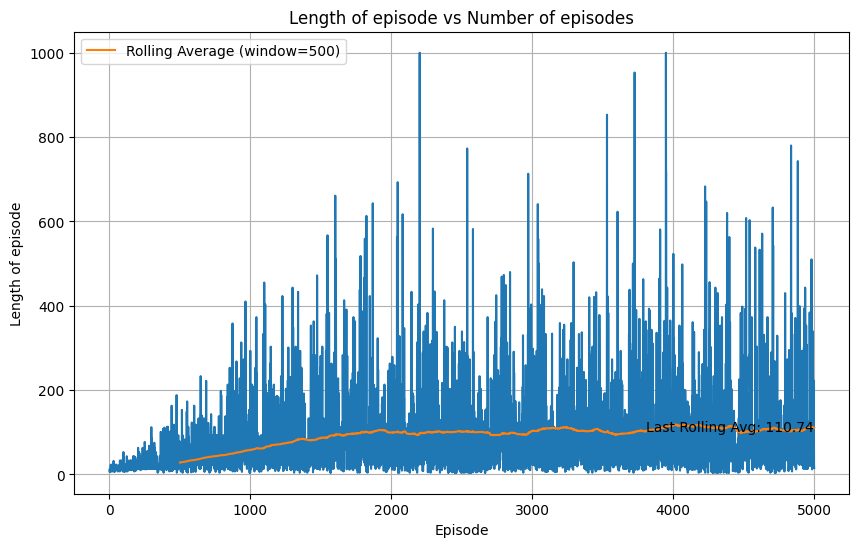

In [46]:
len_episode_plot(len_episodes)

Some epsiodes sky rocket to a reward of 800, but on average, this agent isn't better than the MC one.

In [51]:
play_game_agent(env, trained_agent, sleep_time = 0, num_frames=2000)

Text Flappy Bird!
Score: 199
----------------------
[         |          ]
[      @  |          ]
[                    ]
[                    ]
[                    ]
[                    ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=3,dy=-3)


## Q values

In [52]:
plot_state_values(trained_agent.q)

## Policy

In [53]:
plot_policy(trained_agent.policy)

We can see that the policy is way more sparse, and that some rare states (high distances) have an action of flap while it was not the case in MC ! The behavior are quite different.

# Conclusion

## First Visit Monte Carlo (MC) Method:

-  MC method learns from complete episodes and updates the value function based on the final outcome (i.e., the reward obtained at the end of the episode).

In Flappy Bird, this means that MC method evaluates the entire trajectory of the bird from the start to the end of the game.

Since MC method does not update its estimates until the end of each episode, it may exhibit less risky behavior in passing each pipe. The agent tends to take actions that maximize the cumulative reward over the entire episode, which may lead to more conservative actions to ensure survival until the end of the game.

However, MC method may struggle to learn optimal policies in situations where the consequences of actions are delayed or uncertain. In Flappy Bird, this could result in suboptimal performance in scenarios where the bird needs to take risks to pass pipes efficiently.

##SARSA(λ):

- SARSA(λ) is an online, incremental learning algorithm that updates its estimates after each step based on the observed rewards and transitions. It uses an ε-greedy policy to balance exploration and exploitation.

SARSA(λ) may exhibit riskier behavior in passing each pipe compared to MC method. Since it updates its estimates more frequently and learns from immediate rewards, it has the potential to learn and exploit risky but rewarding actions that may lead to passing pipes more efficiently.

However, this risk-taking behavior can also lead to occasional failures or crashes if the agent takes overly risky actions. SARSA(λ) may explore different strategies more aggressively, which can result in occasional failures before converging to more optimal policies.